<a href="https://colab.research.google.com/github/Jack3690/rgbmaker/blob/main/notebook/Example_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install photutils --quiet
!pip install astroquery --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 26.6 MB/s eta 0:00:00


In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from astropy.table import Table
from astroquery.skyview import SkyView
from astropy.convolution import Gaussian2DKernel,convolve
import astropy.stats as stats
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import LogStretch, SqrtStretch, simple_norm
from astropy.visualization import make_lupton_rgb
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from PIL import Image

from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources

from photutils.background import MMMBackground, Background2D
from astroquery.ipac.ned import Ned
from astroquery.mast import MastClass

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [379]:
surveys_all = []
for i in SkyView.survey_dict.values():
  surveys_all += i

class SkyViewSeg:
    """
    Class for obtaining image data from SkyView and generating segmentation maps.
    """

    def __init__(self, name='4C 36.14', radius=300, pixels=600, surveys=None):
        """
        Initialize the SkyViewSeg object with source details and surveys.

        Parameters
        ----------
        name : str, optional
            Name or coordinate of the source (default: '4C 36.14').
        radius : float, optional
            Radius of the source in arcseconds (default: 300).
        pixels : int, optional
            Number of pixels in the output image (default: 600).
        surveys : list, optional
            List of surveys to obtain data from SkyView. If None, uses a default list.
        """
        self.name = name
        self.radius = radius * u.arcsec
        self.pixels = int(pixels)

        default_surveys = [
            "DSS2 IR", "DSS2 Red", "DSS2 Blue",
            "SDSSg", "SDSSr", "SDSSi",
            "TGSS ADR1", "NVSS", "VLA FIRST (1.4 GHz)"]

        self.surveys = self.validate_surveys(surveys, surveys_all) if surveys or self.log_default() else default_surveys

        self.bands = {}

        for survey in self.surveys:
            for band, survey_list in SkyView.survey_dict.items():
                band = band.split(' ')[0]
                if survey in survey_list:
                    self.bands.setdefault(band, []).append(survey)

        self.radio_surveys = ['TGSS ADR1','NVSS','VLA FIRSR (1.4 GHz)']

    def __call__(self, user_hdu=None):
        """
        Fetch image data from SkyView and store it as HDU objects.

        Parameters
        ----------
        user_hdu : astropy.io.fits.PrimaryHDU, optional
            User-provided HDU to include in the dataset.
        """
        self.hduls = {band: {} for band in self.bands}
        out_survey = []

        for band, surveys in self.bands.items():
            try:
                hduls = SkyView.get_images(
                    position=self.name,
                    radius=self.radius,
                    pixels=self.pixels,
                    scaling="Linear",
                    coordinates='ICRS',
                    survey=surveys
                )
                for i, survey in enumerate(surveys):
                    self.hduls[band][survey] = hduls[i][0]
                    out_survey.append(survey)
            except Exception as e:
                print(f"SkyView failed for {surveys}: {e}")

        self.surveys = out_survey

        if user_hdu and isinstance(user_hdu, fits.PrimaryHDU):
            self.bands['user'] = ['user']
            self.hduls['user'] = {'user': user_hdu}
            self.surveys.append('user')

    def generate_segm(self, surveys=None, box_size=(64, 64), filter_size=(3, 3),
                      sigma=5, npixels=10):
        """
        Generate segmentation maps for the given surveys.

        Parameters
        ----------
        surveys : list, optional
            List of surveys to generate segmentation maps for. Defaults to all loaded surveys.
        box_size : tuple, optional
            Size of the box for background estimation (default: (64, 64)).
        filter_size : tuple, optional
            Size of the filter for background estimation (default: (3, 3)).
        sigma : float, optional
            Sigma for source detection threshold (default: 5).
        npixels : int, optional
            Minimum number of connected pixels for a source (default: 1000).

        Returns
        -------
        list
            List of bands for which segmentation maps were generated.
        """
        user_surveys = surveys or self.surveys
        if not hasattr(self, 'segms'):
            self.segms = {}

        kernel = Gaussian2DKernel(3.0 * stats.gaussian_fwhm_to_sigma, x_size=3, y_size=3)
        kernel.normalize()

        sigma_clip = stats.SigmaClip(sigma=3)
        bkg_estimator = MMMBackground()

        for band, surveys in self.bands.items():
            for survey in surveys:
                if survey not in user_surveys:
                    continue

                hdu = self.hduls[band][survey]
                data = hdu.data.copy()
                wcs = WCS(hdu.header)
                convolved_data = convolve(data, kernel)

                bkg = Background2D(
                    data, box_size=box_size, filter_size=filter_size,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator
                )
                threshold = bkg.background + sigma * bkg.background_rms
                print(f"{survey} RMS(Median): {bkg.background_rms_median}")
                if convolved_data.max() > sigma*bkg.background_rms_median:
                    segm = detect_sources(convolved_data, threshold, npixels=npixels)
                    try:
                      sources = SourceCatalog(data, segm,wcs = wcs)
                      catalog = sources.to_table()
                      # optional format
                      catalog['xcentroid'].info.format = '.2f'
                      catalog['ycentroid'].info.format = '.2f'
                      catalog['kron_flux'].info.format = '.2f'
                    except:
                      print(f"Catalog generation Failed for {survey}")
                      catalog = None
                    self.segms.setdefault(band, {})[survey] = {
                        'data': data,
                        'conv_data': convolved_data,
                        'wcs': wcs,
                        'bkg': bkg,
                        'segm': segm,
                        'catalog': catalog
                    }
                else:
                    print(f"Low SNR data for {survey}")

      # Helper function to validate surveys
    def validate_surveys(self, input_surveys: list, available_surveys: list) -> list:
        """
        Validates a list of input surveys against available surveys.

        Args:
            input_surveys (list): A list of survey names to be validated.
            available_surveys (list): A list of valid survey names.

        Returns:
            list: A list of valid surveys from the input_surveys that exist in available_surveys.
        """
        # Validate input surveys and log unavailable ones
        out_surveys = [s for s in input_surveys if s in available_surveys or self.log_unavailable(s)]
        return out_surveys

    def log_unavailable(self, survey_name: str,) -> bool:
        """
        Logs unavailable survey names. Returns False for chaining in the list comprehension.

        Args:
            survey_name (str): Name of the unavailable survey.

        Returns:
            bool: Always False.
        """
        print(f"{survey_name} not available in SkyView or for this Source")
        return False

    def log_default(self)->bool:
        """
        Logs default surveys. Returns False for chaining in the list comprehension.

        Args:
            survey_name (str): Name of the unavailable survey.

        Returns:
            bool: Always False.
        """
        print("Using Default Surveys")
        return False
    def contour_levels(self, survey):
      if survey=='TGSS ADR1':
        return 0.015
      elif survey=='NVSS':
        return 0.0015
      elif survey=='VLA FIRST (1.4 GHz)':
        return 0.00045

    def display_data(self, surveys, segm=None, contours=None, fig=None, with_segm=False,
                 with_contours=False,  disable_image=False, alpha=0.7,
                 contour_colors=['cyan', 'white', 'red' ,'orange'], cmap='jet',
                 norm_func='sqrt',  norm_lims=[10,99]):
      """
      Function for plotting image, segmentation map, and contours.

      Parameters
      ----------
      surveys: list
          List of survey names to generate images for.
      segm: str, optional
          Name of the survey to plot the segmentation map for.
      contours: list, optional
          List of surveys to plot contours for.
      fig: plt.figure(), optional
          Matplotlib figure object to use for plotting.
      with_segm: bool, optional
          Whether to include segmentation maps in the plot.
      with_contours: bool, optional
          Whether to include contours in the plot.
      contour_colors: list, optional
          List of colors for the contours.
      cmap: str, optional
          Colormap for the main image.
      disable_image: bool, optional
          If True, the main image will not be plotted.

      Returns
      -------
      fig : plt.figure
          The matplotlib figure object.
      axs : list
          List of axes in the figure.
      """

      # Validate input surveys
      if not isinstance(surveys, list):
          print('Error: `surveys` should be a list.')
          return None
      surveys = self.validate_surveys(surveys, self.surveys)
      if not surveys:
          print('Error: No valid surveys provided.')
          return None

      # Validate segmentation map survey
      if with_segm and (segm not in self.surveys):
          print(f'Error: Segmentation survey "{segm}" is not in the input list.')
          with_segm = False

      # Validate contours
      if with_contours:
          if not isinstance(contours, list):
              print('Error: `contours` must be a list of surveys.')
              with_contours = False
          else:
              contours = self.validate_surveys(contours, self.surveys)
              if len(contours) > len(contour_colors):
                  print("Error: Add more contour colors.")
                  with_contours = False
              if not contours:
                  print('Error: No valid contours provided.')
                  with_contours = False

      # Initialize figure if not provided
      if fig is None:
          fig = plt.figure()

      axs = []

      # Ensure segmentation data is available
      if not hasattr(self, 'segms') or not self.segms:
          print('Error: No segmentation data available.')
          return fig, axs

      # Plot data for each survey
      for i, survey in enumerate(surveys):
          survey_found = False
          for key, survey_data in self.segms.items():
              if survey in survey_data:
                  data_entry = survey_data[survey]
                  survey_found = True
                  break

          if not survey_found:
              print(f'Warning: No data found for survey "{survey}".')
              continue

          # Extract data and WCS
          data = data_entry['data']
          wcs = data_entry['wcs']
          title = f"{key} {survey}"

          # Create subplot
          ax = fig.add_subplot(1, len(surveys), i + 1, projection=wcs)

          # Plot main image
          if not disable_image:
              norm = simple_norm(data, norm_func, min_percent=norm_lims[0],
                                 max_percent=norm_lims[1])

              ax.imshow(data, cmap=cmap, norm=norm)

          # Plot segmentation map if enabled
          if with_segm :
              for key, survey_ in self.segms.items():
                if segm in survey_.keys():
                      break
              segm_data = self.segms[key][segm]
              ax.imshow(segm_data['segm'], cmap=segm_data['segm'].cmap,
                        alpha=alpha)
              title += f" with {segm} segmentation map"

          # Plot contours if enabled
          if with_contours:
              legend_handles = []
              legend_labels = []
              for contour_idx, contour_survey in enumerate(contours):
                for key, survey_ in self.segms.items():
                  if contour_survey in survey_:
                      contour_data = self.segms[key][contour_survey]
                      conv_data = contour_data['conv_data']
                      bkg = contour_data['bkg']
                      if contour_survey in self.radio_surveys:
                        min_level = self.contour_levels(contour_survey)
                      else:
                        min_level = 3 * bkg.background_rms_median
                      max_level = conv_data.max()
                      levels = np.linspace(min_level, max_level, 4)
                      contour = ax.contour(conv_data, levels=levels,
                                          colors=contour_colors[contour_idx])
                      h, _ = contour.legend_elements()
                      legend_handles.append(h[0])
                      legend_labels.append(f"Contour: {contour_survey}")

              # Add legend for contours
              if legend_handles:
                  ax.legend(legend_handles, legend_labels)

          ax.set_title(title)
          axs.append(ax)

      return fig, axs

    def nomalize(self,data):
      return (data - np.median(data))/data.max()

    def make_rgb(self, R, G, B, fig=None, stretch=0.1, use_conv=False,
              contours=None, with_contours=True, Q=8, normalize=False,
              norm_func='linear', scale=0.1,
              contour_colors=['cyan', 'white', 'red' ,'orange']):
      """
      Create an RGB image using three surveys and optionally overlay contours.

      Parameters
      ----------
      R : str
          Survey name for the red channel.
      G : str
          Survey name for the green channel.
      B : str
          Survey name for the blue channel.
      fig : matplotlib.figure.Figure, optional
          Figure object for the plot (default: None).
      stretch : float, optional
          Stretch factor for the RGB image (default: 0.1).
      use_conv : bool, optional
          Whether to use convolved data (default: False).
      contours : list, optional
          List of survey names for contour overlays (default: None).
      with_contours : bool, optional
          Whether to overlay contours (default: False).
      contour_colors : list, optional
          List of colors for contours (default: ['blue', 'black', 'red']).

      Returns
      -------
      matplotlib.figure.Figure
          The figure object.
      matplotlib.axes._subplots.WCSAxesSubplot
          The axes of the plot.
      """
      fig = fig or plt.figure(figsize=(10,10))

      # Flags to check if data was found for each channel
      flag_R, flag_G, flag_B = False, False, False
      R_data, G_data, B_data = None, None, None
      wcs = None

      # Search for data in available surveys
      for key, survey_data in self.segms.items():
          if R in survey_data and not flag_R:
              R_data = survey_data[R]['conv_data'] if use_conv else survey_data[R]['data']
              wcs = survey_data[R]['wcs']
              flag_R = True

          if G in survey_data and not flag_G:
              G_data = survey_data[G]['conv_data'] if use_conv else survey_data[G]['data']
              flag_G = True

          if B in survey_data and not flag_B:
              B_data = survey_data[B]['conv_data'] if use_conv else survey_data[B]['data']
              flag_B = True

      # Check if all channels are available
      if not (flag_R and flag_G and flag_B):
          print(f"Missing data: {'R' if not flag_R else ''} {'G' if not flag_G else ''} {'B' if not flag_B else ''}")
          return None, None

      # Create the RGB image
      if normalize:
        R_data = self.nomalize(R_data)
        G_data = self.nomalize(G_data)
        B_data = self.nomalize(B_data)

        if norm_func == 'sqrt':

          R_data = np.sqrt(np.clip(R_data), 0, R_data.max())
          G_data = np.sqrt(np.clip(G_data), 0, G_data.max())
          B_data = np.sqrt(np.clip(B_data), 0, B_data.max())

        elif norm_func == 'log':
          R_data = np.log10(np.clip(R_data, 1e-10, None))
          G_data = np.log10(np.clip(G_data, 1e-10, None))
          B_data = np.log10(np.clip(B_data, 1e-10, None))

        elif norm_func == 'linear':
          R_data = R_data*scale
          G_data = G_data*scale
          B_data = B_data*scale

      RGB = make_lupton_rgb(R_data,
                            G_data,
                            B_data,
                            stretch=stretch,Q=Q)

      # Create the plot
      ax = fig.add_subplot( projection=wcs)
      ax.imshow(RGB)
      ax.set_title(f"R = {R}, G = {G}, B = {B}")

      # Overlay contours if enabled
      if with_contours and contours:
          contours = self.validate_surveys(contours, self.surveys)
          legend_handles = []
          legend_labels = []

          for i, contour_survey in enumerate(contours):
              for key, survey_data in self.segms.items():
                if contour_survey in survey_data:
                    contour_data = survey_data[contour_survey]['conv_data']
                    bkg = survey_data[contour_survey]['bkg']
                    if contour_survey in self.radio_surveys:
                        min_level = self.contour_levels(contour_survey)
                    else:
                        min_level = 3 * bkg.background_rms_median
                    max_level = contour_data.max()
                    levels = np.linspace(min_level, max_level, 4)
                    cont = ax.contour(contour_data, levels=levels, colors=contour_colors[i],zorder=300)
                    h, _ = cont.legend_elements()
                    legend_handles.append(h[0])
                    legend_labels.append(f"Contour: {contour_survey}")

          if legend_handles:
              ax.legend(legend_handles, legend_labels)

      return fig, ax


In [380]:
sks = SkyViewSeg(f'speca', radius=150)
sks()

Using Default Surveys


In [381]:
sks.generate_segm(sigma=3)

DSS2 IR RMS(Median): 141.65725708007812
DSS2 Red RMS(Median): 241.814697265625
DSS2 Blue RMS(Median): 225.83514404296875
SDSSg RMS(Median): 0.018169686198234558
SDSSr RMS(Median): 0.028201185166835785
SDSSi RMS(Median): 0.05041898041963577
TGSS ADR1 RMS(Median): 0.002546625444665551
NVSS RMS(Median): 0.0004246191238053143
VLA FIRST (1.4 GHz) RMS(Median): 0.0001522800448583439


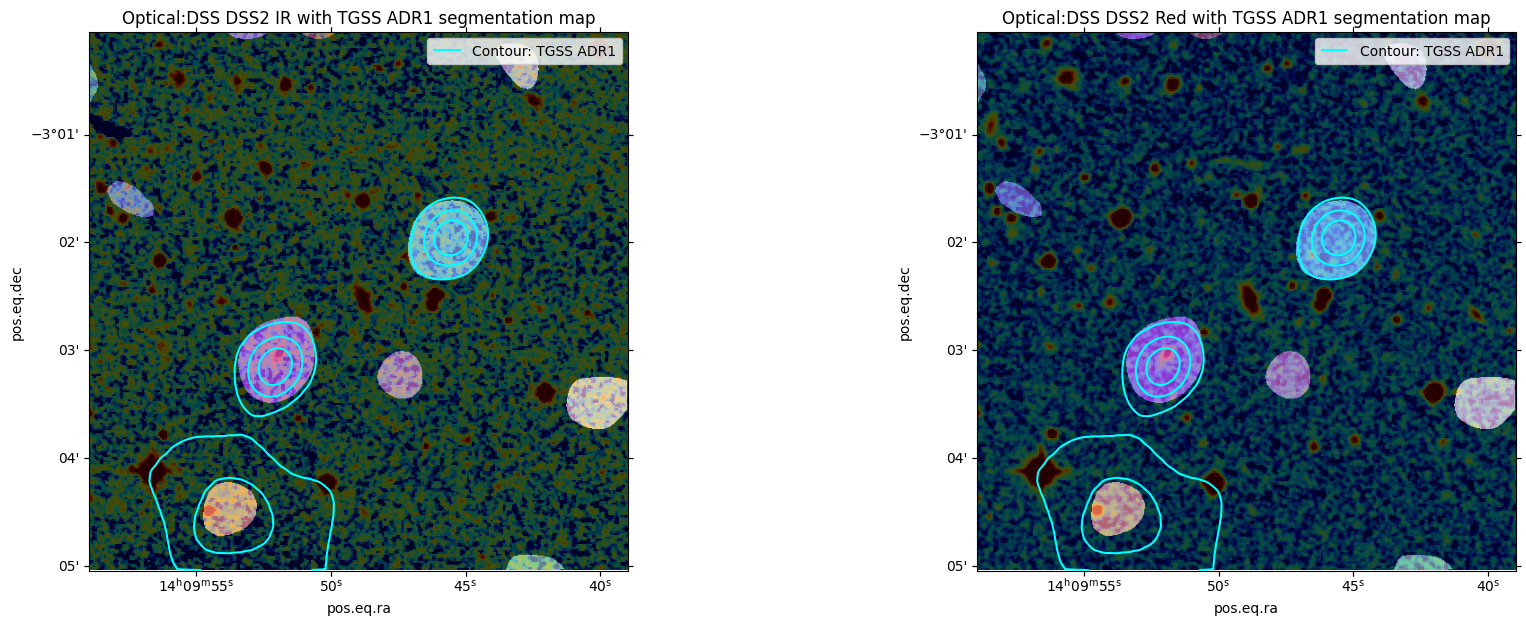

In [382]:
fig,axs = sks.display_data(['DSS2 IR','DSS2 Red'],
                          fig=plt.figure(figsize=(21,7)),
                          with_segm=True,
                          segm = 'TGSS ADR1',
                          with_contours=True,
                          contours=['TGSS ADR1'],
                          cmap='jet',
                          disable_image=False)

(<Figure size 700x700 with 1 Axes>,
 <WCSAxes: title={'center': 'R = SDSSi, G = SDSSr, B = SDSSg'}>)

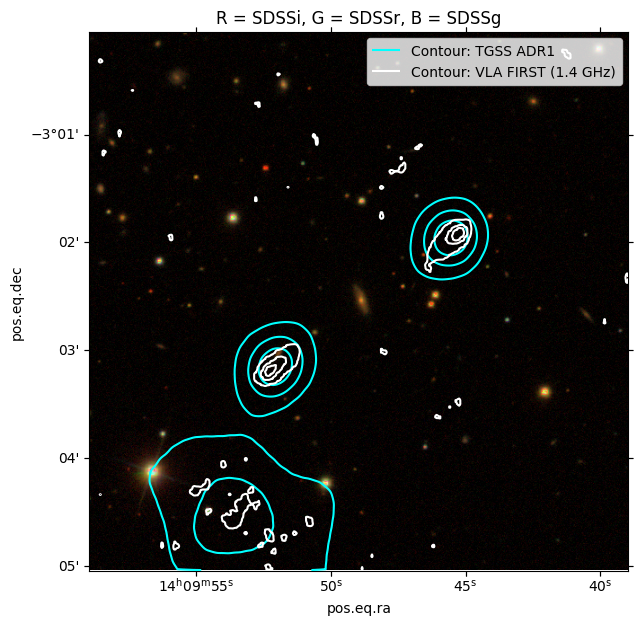

In [383]:
fig= plt.figure(figsize=(7,7))
sks.make_rgb('SDSSi','SDSSr', 'SDSSg', stretch=1,
             with_contours=True, fig=fig,
             contours=['TGSS ADR1','VLA FIRST (1.4 GHz)'])